# Merge ANUCLIM Rainfall with Satellite Rainfall

Australia's has high resolution gridded datasets built from spatial interpolation of the extensive weather stations across Aus. However, in locations where the the station denisity is low, the interpolations are suspect. IN these location we will attempt to replace the sptially interpoled gridded data with satellite retriveals of rainfall.

In [1]:
import shapely
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from odc.geo.xr import assign_crs
from odc.geo.geobox import GeoBox
from odc.geo.xr import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.spatial import xr_rasterize

## Read weather stations list, filter, then convert to geopandas, clip to Aus mainland

In [2]:
df = pd.read_csv('/g/data/os22/chad_tmp/NEE_modelling/data/weather_stations.csv')
df.head()

,Site,Dist,Site name,Start,End,Lat,Lon,Source,STA,Height (m),Bar_ht,WMO
0,1000,1,KARUNJIE,1940,1983,-16.2919,127.1956,.....,WA,320,..,..
1,1001,1,OOMBULGURRI,1914,2012,-15.1806,127.8456,GPS,WA,2,..,..
2,1002,1,BEVERLEY SP,1959,1967,-16.5825,125.4828,.....,WA,..,..,..
3,1003,1,PAGO MISSION,1908,1940,-14.1331,126.7158,.....,WA,5,24.4,..
4,1004,1,KUNMUNYA,1915,1948,-15.4167,124.7167,.....,WA,47,..,..


In [3]:
# filter datasets to stations that existed after 2002
df['End'] = np.where(df['End']=='..', 2022, df['End'])
df['End'] = df['End'].astype(int)
df = df[df['End']>=2002]

In [4]:
#convert to geopandas
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Lon, df.Lat))
gdf.crs='EPSG:4326'

#clip to Aus mainland
aus = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/aus_bbox.geojson')
gdf = gdf.clip(aus)
gdf

,Site,Dist,Site name,Start,End,Lat,Lon,Source,STA,Height (m),Bar_ht,WMO,geometry
3103,14086,14GA,BEATRICE HILL,1971,2022,-12.6495,131.3181,GPS,NT,77,..,..,POINT (131.31810 -12.64950)
3293,14276,14GA,WILDMAN RIVER PLANTATIONS,1984,2012,-12.6415,131.8851,GPS,NT,30,..,..,POINT (131.88510 -12.64150)
3106,14089,14GA,DS25,1992,2022,-12.6354,131.2847,GPS,NT,13,..,..,POINT (131.28470 -12.63540)
3111,14094,14GA,DS24,1992,2022,-12.6331,131.2619,GPS,NT,11,..,..,POINT (131.26190 -12.63310)
3114,14097,14GA,DS23,1992,2022,-12.6231,131.3047,GPS,NT,14,..,..,POINT (131.30470 -12.62310)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,9661,09A,ROCKY GULLY TOWN,1954,2022,-34.5097,117.0117,GPS,WA,200,..,..,POINT (117.01170 -34.50970)
19283,109514,09A,TREEN BROOK (KING TROUT),2011,2011,-34.4986,116.0008,GPS,WA,110,..,..,POINT (116.00080 -34.49860)
1426,9561,09A,KENDENUP,1901,2022,-34.4858,117.6289,GPS,WA,262,..,..,POINT (117.62890 -34.48580)
1366,9501,09A,ARUNDEL,1912,2022,-34.4736,117.4800,GPS,WA,260,..,..,POINT (117.48000 -34.47360)


## Create 1x1 degree grid over Aus

In [5]:
#how many degrees shiuld the cell size be?
cell_size = 1

# total area for the grid
xmin, ymin, xmax, ymax= aus.total_bounds

n_cells = cell_size*(xmax-xmin)
print(n_cells)
# projection of the grid
crs = gdf.crs
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)

42.71484375


(111.098545, 157.658355, -45.338135, -8.370764999999999)

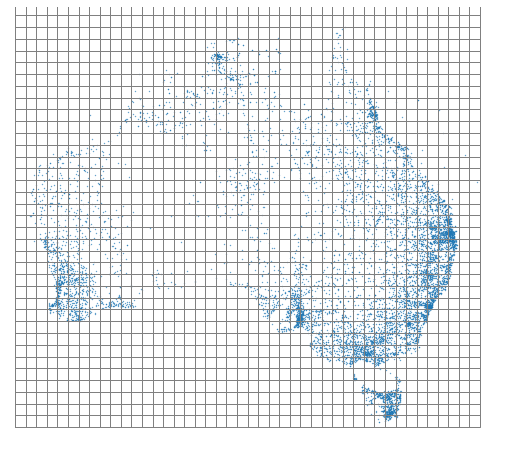

In [6]:
ax = gdf.plot(markersize=.1, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

## Create density map of number of stations per grid cell

In [7]:
merged = gpd.sjoin(gdf, cell, how='left', predicate='within')

# make a simple count variable that we can sum
merged['n_stations']=1

# Compute stats per grid cell -- aggregate stations to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")

# put this into cell
cell.loc[dissolve.index, 'n_stations'] = dissolve.n_stations.values

#convert cell with NaN to zero
cell['n_stations'] = cell['n_stations'].fillna(0)


In [8]:
# # clip to Aus mainland outline again
# aus = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/aus_outline/AUS_2021_AUST_GDA2020.shp').to_crs('epsg:4326')
# aus = aus[aus['AUS_NAME21']=='Australia']
# cell = cell.clip(aus)

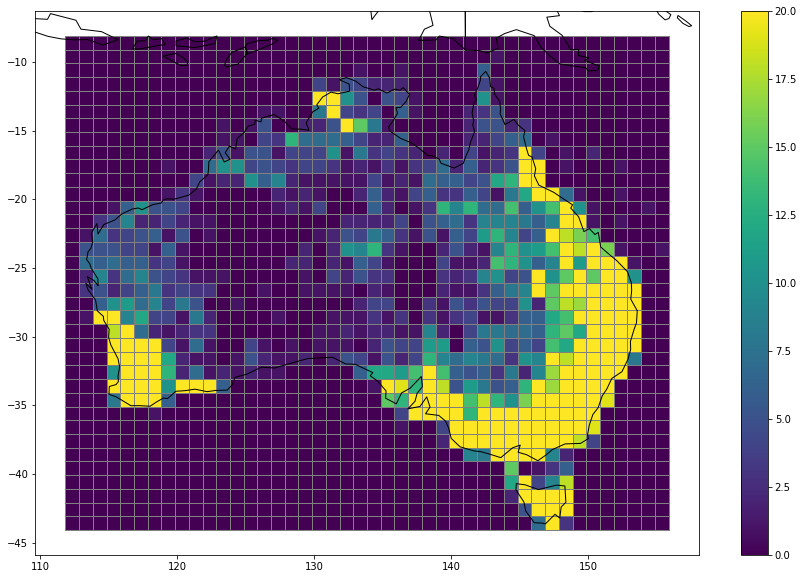

In [9]:
ax = cell.plot(column='n_stations', figsize=(15, 10), cmap='viridis',edgecolor="grey", vmax=20, vmin=0, legend=True)
plt.autoscale(False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(cell.crs).plot(ax=ax, color='none', edgecolor='black');
# ax.axis('off')

## Replace rainfall at low density stations regions

Open ANUClim rainfall and 

In [10]:
chirps = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/chirps_5km_monthly_1991_2021.nc').isel(time=-1)

anu = xr.open_dataset('https://dapds00.nci.org.au/thredds/dodsC/gh70/ANUClimate/v2-0/stable/month/rain/2021/ANUClimate_v2-0_rain_monthly_202112.nc')
anu = assign_crs(anu, crs='EPSG:4283')
anu = anu.rain.squeeze()
anu.attrs['nodata'] = np.nan

anu = xr_reproject(anu, chirps.odc.geobox, resampling='average')
anu['latitude'] = anu.latitude.astype('float32')
anu['longitude'] = anu.longitude.astype('float32')

### Rasterize and clip to extent of ANU Rainfall

In [11]:
da_stations = xr_rasterize(cell, chirps, attribute_col='n_stations')
da_stations = da_stations.where(~np.isnan(chirps))

In [12]:
few_stations  = da_stations < 2

In [13]:
merged_rainfall = xr.where(few_stations==True, chirps, anu)

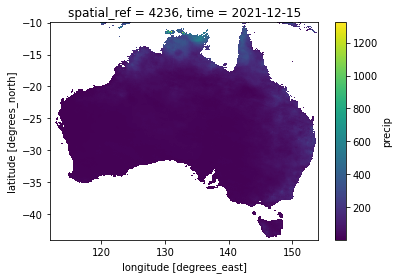

In [16]:
chirps.plot.imshow()

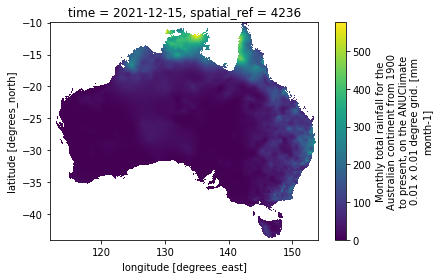

In [17]:
anu.plot.imshow()

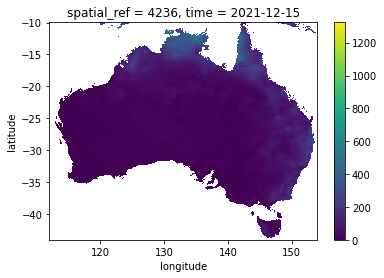

In [15]:
merged_rainfall.plot.imshow()

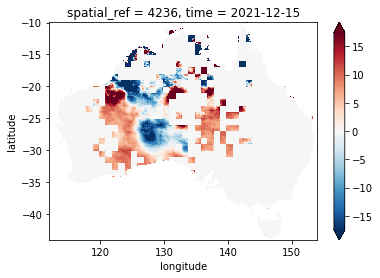

In [14]:
(merged_rainfall - anu).plot.imshow(robust=True)